# L’apprentissage non supervisé

## Implémentation d’une méthode de clustering avec Python

Dans le cas d’un clustering les données consiste en un bloc de variables x
desquelles on va extraire des groupes d’observations.

Nous allons appliquer les k-means directement sur les données. Les k-means
(k-moyennes) sont donc un algorithme d’apprentissage non supervisé permettant
de construire des classes d’observations à partir d’un jeu de données de grande
dimension.

## Préparation des données

Les données que nous utilisons sont des données sur les communes d’Île-de-
France et leur caractéristiques socio-démographiques. 

Notre objectif est ici de comprendre s’il existe des classes de communes ayant des caractéristiques proches.
On obtiendra ainsi une typologie des communes d’Île-de-France et on pourra représenter
ces groupes sur une carte.

Nous allons préparer ces données qui sont disponibles sur le site du livre. Une
description est disponible au début du chapitre 4.m

In [1]:
import pandas as pd
import numpy as np
# on récupère le fichier csv
data=pd.read_csv("./Data/base-dpt.csv",sep=";")
# on enlève des variables avec trop de données manquantes
data.drop(["PIMP14","TP6014"],axis=1,inplace=True)
# on enlève les observations avec des données manquantes
data.dropna(inplace=True)
# on extrait dans un DataFrame la position géographique des comunes
position=pd.DataFrame(data["geo_point_2d"])
# on crée une colonne longitude en prenant la première partie
# de la colonne geo_point_2
position["longitude"]=pd.to_numeric(position["geo_point_2d"].str.split(',')\
                                    .str.get(0))
# on fait la même chose pour la latitude
position["latitude"]=pd.to_numeric(position["geo_point_2d"].str.split(',')\
                                   .str.get(1))
# finalement, on sélectionne uniquement les données numériques
# pour faire notre K-means et on enlève trois variables inutiles
x=data.select_dtypes(np.number).drop(["CODGEO","REG","DEP"],axis=1)

In [2]:
x

,P14_POP,P09_POP,SUPERF,NAIS0914,DECE0914,P14_MEN,NAISD16,DECESD16,P14_LOG,P14_RP,...,P14_ACT1564,ETTOT15,ETAZ15,ETBE15,ETFZ15,ETGU15,ETGZ15,ETOQ15,ETTEF115,ETTEFP1015
0,20996.0,20258.0,2.42,1564.0,749.0,8909.817815,257.0,156.0,9337.392497,8909.817815,...,10146.844242,1475.0,3.0,38.0,142.0,1078.0,225.0,214.0,335.0,67.0
1,8155.0,7920.0,9.21,639.0,243.0,2891.000000,152.0,46.0,3086.000000,2891.000000,...,4044.000000,878.0,8.0,47.0,135.0,623.0,241.0,65.0,228.0,72.0
2,242.0,229.0,3.89,9.0,4.0,93.154812,1.0,1.0,106.271929,93.154812,...,109.355649,13.0,2.0,0.0,2.0,5.0,2.0,4.0,4.0,0.0
3,446.0,447.0,4.61,18.0,21.0,186.507593,0.0,6.0,267.570530,186.507593,...,204.811694,74.0,0.0,6.0,6.0,48.0,17.0,14.0,13.0,4.0
4,838.0,828.0,9.82,45.0,29.0,340.831981,5.0,9.0,364.250976,340.831981,...,400.064890,75.0,6.0,3.0,8.0,53.0,12.0,5.0,14.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,26826.0,25856.0,4.78,2111.0,753.0,10363.061937,366.0,149.0,11028.844943,10363.061937,...,13742.201794,1948.0,3.0,60.0,273.0,1365.0,297.0,247.0,419.0,86.0
1296,15072.0,14783.0,5.24,910.0,551.0,6033.502470,197.0,97.0,6358.662532,6033.502470,...,7400.243545,1396.0,3.0,71.0,199.0,876.0,177.0,247.0,301.0,45.0
1297,177.0,176.0,3.26,14.0,3.0,70.000000,5.0,1.0,88.000000,70.000000,...,98.000000,25.0,5.0,3.0,6.0,9.0,3.0,2.0,9.0,0.0
1298,278.0,259.0,7.58,17.0,5.0,109.978022,6.0,1.0,122.384802,109.978022,...,139.509158,41.0,5.0,1.0,1.0,31.0,10.0,3.0,10.0,2.0


## Validation du modèle et choix du nombre de classes
Dans le cas du clustering, il est très difficile de valider le modèle avec des indicateurs
statistiques. En effet, on ne peut pas tester la qualité prédictive. Nous allons
essayer de faire en sorte d’obtenir des classes les plus homogènes possibles et de
minimiser l’inertie. 

Afin de choisir le nombre de classe à utiliser on peut utiliser un
graphique. Elle représente l’inertie par nombre de classes. On recherche un coude
dans cette courbe pour décider le nombre à retenir.

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# on crée une liste dans laquelle on stocke les inerties
inerties=[]
# on fait une boucle de 2 à 9 pour tester toutes ces possibiliéts
for k in range(2, 10):
    # pour chaque k, on crée un modèle et on l’ajuste
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(x)
    # on stocke l’inertie associée
    inerties.append(kmeans.inertia_)

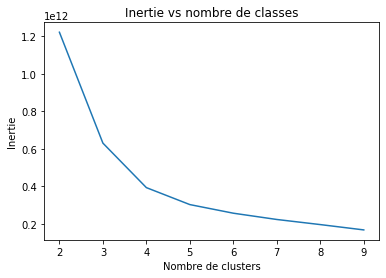

In [5]:

# on représente le graphique
fig=plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), inerties)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title('Inertie vs nombre de classes')
plt.savefig("./elbow.png")


## Application des k-means
Pour appliquer les k-means sur nos données, on utilisera :

In [6]:
from sklearn.cluster import KMeans
modele_km = KMeans(n_clusters=4)
modele_km.fit(x)

KMeans(n_clusters=4)

In [7]:
modele_km.labels_

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [8]:
# on stocke les classes d’appartenance dans classes
classes=modele_km.labels_
# on crée un DataFrame avec le nombre d’individus par calsse
count=pd.DataFrame(np.unique(classes,return_counts=True)[1],
columns=["Nombre d’individus"])
# on stocke les centres des classes dans un DataFrame
centres=pd.DataFrame(modele_km.cluster_centers_,columns=x.columns)
# on affiche le DataFrame avec les deux informations
pd.set_option('precision',2)
print(pd.concat([count,pd.DataFrame(centres,columns=x.columns)],axis=1).T)
pd.reset_option('precision')

                           0         1          2         3
Nombre d’individus    172.00   1063.00      10.00     32.00
P14_POP             30048.72   2520.14  177206.80  75067.59
P09_POP             29077.12   2438.52  177166.40  73660.69
SUPERF                  8.59      9.48       8.21      8.29
NAIS0914             2467.56    157.02   12244.80   6120.00
DECE0914              872.23     77.66    5637.90   2127.72
P14_MEN             12136.82    971.20   90563.71  32671.56
NAISD16               486.42     30.86    2333.60   1192.66
DECESD16              181.58     17.10    1147.60    428.94
P14_LOG             13126.00   1065.33  104668.51  36851.11
P14_RP              12136.82    971.20   90563.71  32671.56
P14_RSECOCC           232.42     30.34    6173.12   1688.96
P14_LOGVAC            756.76     63.78    7931.68   2490.60
P14_RP_PROP          5693.89    669.37   29323.08  13125.46
NBMENFISC14         11736.59    958.26   82067.90  30785.59
MED14               22238.60  25363.69  

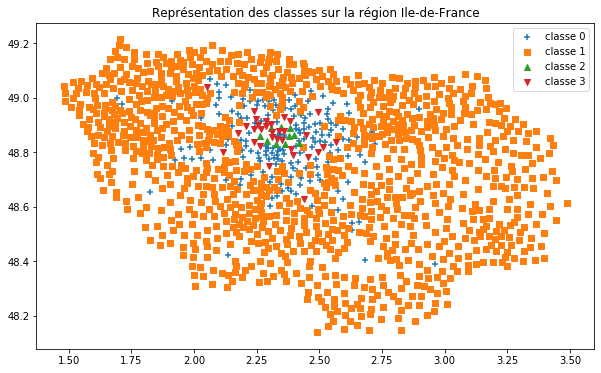

In [9]:

# on crée une figure
plt.figure(figsize=(10,6))
# on fait une boucle sur les classes en définissant des marqueurs par classe
markers=["+","s","^","v"]
for val, mark in zip(np.unique(classes),markers):
    plt.scatter(position["latitude"][classes==val],
                position["longitude"][classes==val], marker=mark,
                label="classe% i"%(val))
plt.title("Représentation des classes sur la région Ile-de-France")
plt.legend()
plt.savefig("./idf2.png")

On voit que les quatre classes se répartissent très bien sur l’Ile-de-France avec :
- Classe 0 : petites communes éloignées de Paris
- Classe 1 : grandes communes de la petite ceinture
- Classe 2 : arrondissements extérieurs de Paris (12 à 20)
- Classe 3 : communes moyennes moins proches de Paris

**Exercice :**
    
Traitement d'image avec les Kmeans

On veut changer le nombre de couleur d'une photo de la tour Eiffel avec les K-means

In [10]:
tour_eiffel = plt.imread("./Data/tour-eiffel.png")

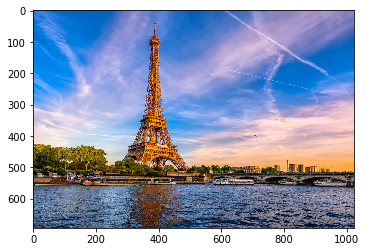

In [11]:
plt.imshow(tour_eiffel)

On commence par empiler les pixels dans un format avec 2 dimension (3 colonnes et autant de lignes que de pixels)

**Indice :** On utilise `.reshape()`

On applique les k-means sur l'array obtenu avec n_clusters égal au nombre de couleurs voulu.

On obtient les labels de chaque pixel (la classe) et la couleur centrale de chaque classe.

On utilise`.labels_` et `.cluster_centers_`

On peut utiliser le code 
```
new_image = centers[label].reshape(tour_eiffel.shape)
```
pour reconstruire l'image. Il reste alors à l'afficher.

## Les méthodes de réduction de dimension

Parmi les algorithmes non supervisés, on inclut souvent des méthodes qui permettent de réduire le nombre de dimensions de vos données. Nous allons présenter
l’utilisation de trois d’entre elles : l’analyse en composantes principales et deux
méthodes non linéaires.

Les méthodes de réduction de dimensions se divisent en deux familles : les
méthodes linéaires et les méthodes non linéaires.

### Méthodes linéaires
Il s’agit de méthodes d’analyse de données souvent bien connues. On pourra citer :

- l’analyse en composantes principales (ACP/PCA)
- l’analyse en composantes indépendantes
- la décomposition en valeurs singulières
- l’analyse factorielle
- les analyses multi-tableaux

Et pour des données qualitatives :
   
- l’analyse des correspondances multiples

Scikit-Learn possède de nombreuses approches mais nous allons nous concentrer sur une application de l’analyse en composantes principales.

## Application de l'ACP
Nous utilisons une base de données d’images : celle du jeu de données Fashion-
MNIST qui rassemble des photographies de vêtements (un vêtement par image).
Ces données sont directement disponibles dans le package Keras. Nous allons utiliser l’ACP pour réduire la complexité de ces images. 

In [12]:
%matplotlib inline
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

In [13]:
# on récupère les données dans 4 arrays
(train_img, train_lbl), (test_img, test_lbl)=fashion_mnist.load_data()
# ce jeu de données d’apprentissage est composé de 600000 images
# ayant 28 x 28 pixels en noir et blanc
train_img.shape

(60000, 28, 28)

In [14]:
# l’image 801 a le label 9: chaussure
train_lbl[100]

8

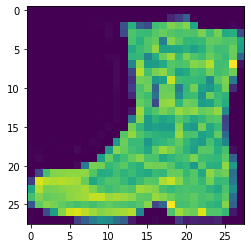

In [15]:
plt.imshow(train_img[150])

Nous avons donc récupéré des images de taille 28 par 28 qui sont stockées dans
un array avec une image par ligne.

L’objectif est de réduire le nombre d’informations nécessaires à l’apprentissage de ces images en vue d’appliquer un modèle prédictif. Nous allons voir comment simplifier ces images en utilisant toutes les données :

In [16]:
# on passe les images en deux dimensions
img_acp=train_img.reshape(train_img.shape[0],-1)

# on crée un modèle d’ACP
pca=PCA(n_components=.80)

# on réduit le nombre de dimensions avec l’ACP
donnees_reduites=pca.fit_transform(img_acp)

# Pour capturer 80% de l’information, on utiliser 43 des 784 composantes
# on projette les données réduites dans l’espace d’origine
projection=pca.inverse_transform(donnees_reduites)

donnees_reduites.shape

(60000, 24)

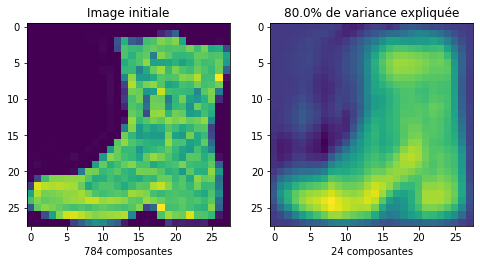

In [17]:
# on affiche les résultats
plt.figure(figsize=(8,4));
# image initale
plt.subplot(1, 2, 1);
plt.imshow(img_acp[150].reshape(28,28))
plt.xlabel('%i composantes'%(img_acp.shape[1]))
plt.title('Image initiale');
# image basée sur l’ACP
plt.subplot(1, 2, 2);
plt.imshow(projection[150].reshape(28, 28))
plt.xlabel('%i composantes' %(donnees_reduites.shape[1]))
plt.title('%s de variance expliquée'%(str(pca.n_components*100)+"%"))
plt.savefig("transfo.png")

## Aller plus loin

De nombreuses autres méthodes de machine learning non supervisé sont disponibles. La documentation de scikit-learn vous aidera à en avoir un aperçu très lare :
    
- Clustering : 

http://scikit-learn.org/stable/modules/clustering.html#clustering


- Réduction de dimension : 

http://scikit-learn.org/stable/modules/decomposition.html#decompositions